In [538]:
import pandas as pd
import numpy as np
import imutils
from os import listdir
import seaborn as sns

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import optuna
from xgboost_autotune import fit_parameters
from scipy import stats

data_train_path = './data/noisySvin/Выдосы нарезанные/'

In [539]:
df = pd.DataFrame({'filename' : [], 'mean' : [], 'std' : [], 'max' : [], 'median' : [], 'freq' : []})

for csv_path in listdir(data_train_path):
    for csv_file in listdir(data_train_path + csv_path):
        if csv_file.split('.')[-1] == 'csv':
            sub_df = pd.read_csv(data_train_path + csv_path + '/' + csv_file)
            sub_df = sub_df.loc[:, sub_df.columns.str.contains('^Unnamed')]


            
            sub_mean = np.exp(sub_df.mean().item()/10)
            sub_std = np.exp(sub_df.std().item()/10)
            sub_max = np.exp(sub_df.max().item()/10)
            sub_median = np.exp(sub_df.median().item()/10)
            sub_freq = int(csv_path.split()[-1])

            df_to_merge = pd.DataFrame({'filename' : [csv_file], 'mean' : [sub_mean], 'std' : [sub_std], 'max' : [sub_max], 'median' : [sub_median], 'freq' : [sub_freq]})
            df = pd.concat([df, df_to_merge])

In [540]:
df.loc[df['freq'] == 0]['max'].mean()

9.640756563336815e+55

In [541]:
df.to_csv('aggr.csv')
df.drop('filename', axis=1, inplace=True)

/home/dan1ar/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='median', ylabel='freq'>

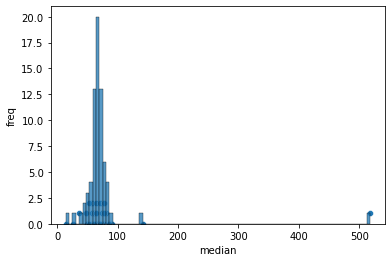

In [542]:
df = df[df['max'] < df['max'].quantile(0.95)]
sns.scatterplot(df['median'], df.freq)
sns.histplot(df['median'])

In [543]:
X = df.drop(['freq'], axis=1)
y = df['freq']

In [544]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = XGBClassifier()
params = {'n_estimators': stats.randint(10, 100),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

rs_clf = RandomizedSearchCV(model, params)
rs_clf.fit(X_train, y_train)

best_model = rs_clf.best_estimator_
best_params_rand = rs_clf.best_params_
best_params_rand

gs.warn("Estimator fit failed. The score on this train-test"
/home/dan1ar/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dan1ar/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dan1ar/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dan1ar/.local/lib/python3.8/site-pa

{'colsample_bytree': 0.6998643943539797,
 'learning_rate': 0.013920148775638644,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 73,
 'subsample': 0.8109897621099875}

[09:32:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7083333333333334


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

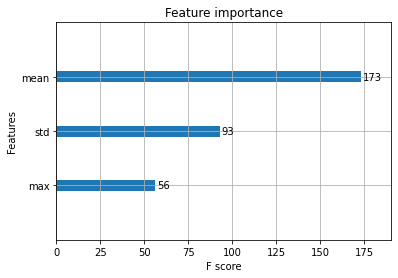

In [545]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print( accuracy_score(y_pred, y_test) )
plot_importance( best_model )

In [546]:
#FEATURE ENG

df_gr = df.groupby('freq').apply(len)
df_gr.head()

freq
0.0    46
1.0    17
2.0     8
dtype: int64

/home/dan1ar/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mean', ylabel='max'>

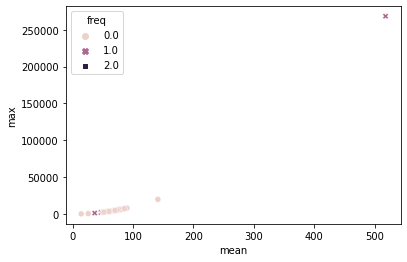

In [547]:
sns.scatterplot(df['mean'], df['max'], hue=df['freq'], sizes=df['freq'], style=df['freq'])

In [548]:
best_model.save_model('best_model.json')